In [6]:
%load_ext autoreload
%autoreload 2

import pprint
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import environment
import td_n_step_sarsa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
def to_arrow(pi):
    directions = []
    arrows = ["↑", "→", "↓", "←"]
    for actions in pi:
        for i in range(len(actions)):
            if actions[i] > 0:
                directions.append(arrows[i])
    
    return directions

def run(grid, agent):
    grid_actions = 4
    # env
    env = environment.create(grid=grid, step_reward=-1, cliff_reward=-100)

    # S, A
    n_row = len(grid)
    n_col = len(grid[0])
    S = [s for s in range(n_row * n_col)]
    A = [a for a in range(grid_actions)]
    
    bootstraps = ["sarsa", "expected", "q"]
    results = []
    n_runs = 25
    
    for bootstrap in bootstraps:
        agent["bootstrap"] = bootstrap
        error_histories = []
        length_histories = []
        visit_counts = []
        q, pi = None, None
        
        for i in tqdm(range(n_runs)):
            q, pi, log = td_n_step_sarsa.learn(S, A, env, agent)
            error_history, length_history, visit_count = log
            
            error_histories.append(error_history)
            length_histories.append(length_history)
            visit_counts.append(visit_count)
        
        results.append((bootstrap, np.average(error_histories, axis=0), 
                        np.average(length_histories, axis=0), np.average(visit_counts, axis=0)))
    
    return results

plt.rcParams['figure.figsize'] = [10, 5]

def plot(title, data):
    for d in data:
        plt.plot(d[1], label=d[0])
    plt.title(title)
    plt.legend()
    plt.show()
    

100%|██████████| 25/25 [00:10<00:00,  2.31it/s]


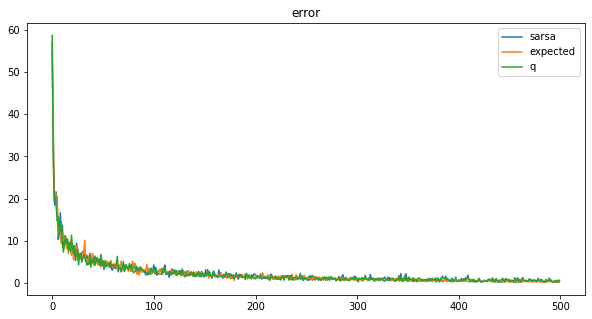

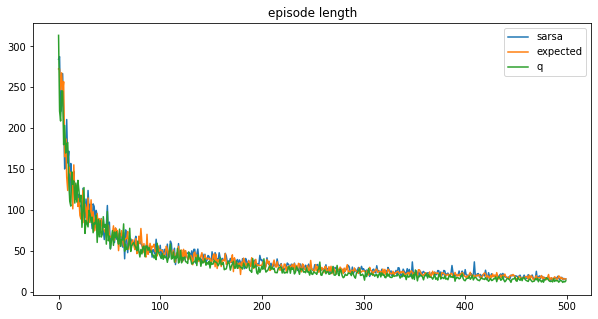

visit count last 20 episodes
sarsa
[[ 4.48  4.28  3.84  3.16  2.76  2.32  2.2 ]
 [ 5.2   4.6   4.04  3.32  2.56  2.12  1.96]
 [ 7.6   5.6   4.52  3.88  3.72  2.92  3.  ]
 [19.52 15.8  14.   13.8  14.52 14.72 16.16]
 [21.44  4.16  2.52  2.16  1.72  3.16 18.36]
 [23.16  0.    0.    0.    0.    0.   19.  ]
 [ 5.68  3.04  3.8   2.4   2.92  2.12  2.  ]]
expected
[[ 5.4   4.88  4.36  3.84  2.88  2.04  2.2 ]
 [ 6.64  6.04  4.84  4.    3.6   2.12  1.4 ]
 [ 8.16  6.68  5.28  4.16  3.68  3.04  3.08]
 [20.8  15.52 14.2  14.2  14.52 15.52 17.84]
 [22.32  3.24  1.84  1.6   1.12  1.64 18.88]
 [22.24  0.    0.    0.    0.    0.   19.  ]
 [ 7.16  3.    2.48  2.24  2.04  1.6   1.52]]
q
[[ 2.24  2.36  2.24  1.68  1.12  0.88  0.76]
 [ 3.08  2.12  1.8   1.8   1.16  0.8   0.92]
 [ 3.64  2.92  2.48  2.32  1.4   0.84  0.76]
 [ 4.88  3.8   2.84  2.48  2.08  1.56  1.68]
 [13.88 10.2   9.68  9.68  9.84 10.32 11.44]
 [24.36  0.    0.    0.    0.    0.   19.  ]
 [12.4  11.04 10.28  9.96  9.72  9.8   9.56]]


In [53]:
# online learning without background planning
grid = [
    ".......",
    ".......",
    ".......",
    ".......",
    ".......",
    "SCCCCCT",
    "......."
]

# agent
agent = {
    "discount": 0.9,
    "step_size": 0.05,
    "epsilon": 0.1,
    "trace_length": 3,
    "n_iterations": 500,
    "learn_online": True,
    "plan_background": False
}

results = run(grid, agent)

plot("error", [(result[0], result[1]) for result in results])
plot("episode length", [(result[0], result[2]) for result in results])

print("visit count last 20 episodes")
for result in results:
    print(result[0])
    print(result[3].reshape((7, 7)))

100%|██████████| 25/25 [00:07<00:00,  3.13it/s]


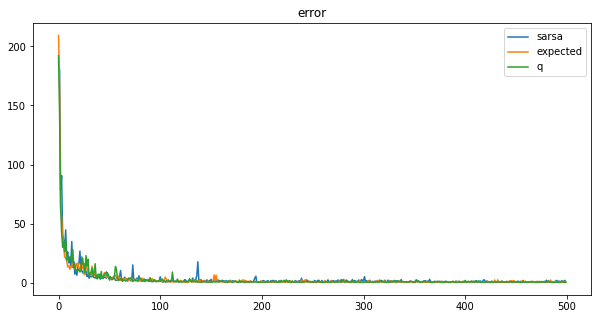

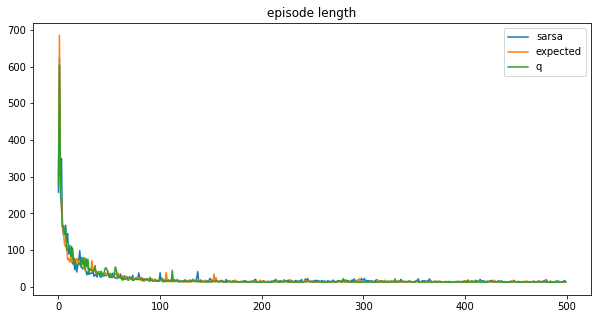

visit count last 20 episodes
sarsa
[[ 0.08  0.12  0.32  0.56  0.4   0.72  1.12]
 [ 0.6   0.44  0.76  0.84  0.8   0.72  0.36]
 [ 5.36  7.12  7.32  8.04  7.92  7.92  5.96]
 [20.6  16.32 14.68 15.2  14.08 15.08 20.24]
 [21.12  1.24  0.64  1.28  1.2   1.28 20.36]
 [21.48  0.    0.    0.    0.    0.   19.  ]
 [ 2.16  0.08  1.68  0.04  0.    0.    0.  ]]
expected
[[ 1.76  0.4   0.68  0.36  0.44  0.32  0.16]
 [ 1.    0.52  0.6   0.56  0.48  0.4   0.28]
 [ 1.12  1.08  1.48  1.72  1.64  1.44  1.48]
 [19.4  19.52 20.12 19.96 19.44 19.16 20.56]
 [20.8   1.72  0.72  0.84  0.88  1.48 20.68]
 [21.32  0.    0.    0.    0.    0.   19.  ]
 [ 2.12  0.32  0.28  0.68  1.32  0.2   0.04]]
q
[[ 0.28  0.16  0.    0.    0.    0.    0.  ]
 [ 0.76  0.36  0.12  0.08  0.08  0.08  0.08]
 [ 0.84  1.16  0.88  0.92  1.2   0.88  0.92]
 [20.36 20.72 20.52 20.08 19.88 19.48 20.04]
 [20.64  1.12  0.84  0.72  0.92  1.56 20.36]
 [21.2   0.    0.    0.    0.    0.   19.  ]
 [ 0.76  0.08  0.12  0.44  0.16  0.12  0.08]]


In [54]:
# online learning with background planning
agent["plan_background"] = True

results = run(grid, agent)

plot("error", [(result[0], result[1]) for result in results])
plot("episode length", [(result[0], result[2]) for result in results])

print("visit count last 20 episodes")
for result in results:
    print(result[0])
    print(result[3].reshape((7, 7)))
